# Taking a Look at GestureVis

In GestureVis, `annotation.py` handles the actual annotation and only depends on Numpy and Matplotlib. It tracks hand data via a skeleton in 3D space, where each vertex is a collection of X, Y, and Z coordinates. The `gesture_vis.py` script handles running PoseVis to collect and convert MediaPipe keypoints into a format that the annotator expects.
The data in this notebook is generated through MediaPipe, but it could easily be from any other hand tracking solution.

MediaPipe generates a 21-point skeleton:

![skeleton](https://mediapipe.dev/images/mobile/hand_landmarks.png)

# Initializing the Annotator

Let's create the annotator object and load the included gestures:
See the [readme](readme.md) for information on how to easily add gestures to `gestures.json`.

In [21]:
from pose_vis.utils import absolute_path
from pose_vis.gesture.hand.annotation import Annotation, Vector

annotation = Annotation()
# Two gestures are included in data/gestures.json: "Peace" and "Thumbs Up"
annotation.load_gestures(absolute_path("hand/data/gestures.json"))

# Adding Hand Vertices

The included gestures are a 21-point list of vertices, and the annotator expects the hands to be as well. It's hard to do this manually, so I recorded two poses with `gesture_vis.py`, and we'll load that data. All units are in milimeters, with their origin being the approximate geometric center of the hand. Find out more at the [MediaPipe documentation](https://google.github.io/mediapipe/solutions/hands.html#multi_hand_world_landmarks).

In [23]:
# Thumbs up approximation
pose_1 = """
[
    [
        37.49,
        43.01,
        78.26
    ],
    [
        11.91,
        12.52,
        69.02
    ],
    [
        4.26,
        -12.75,
        62.93
    ],
    [
        -1.0,
        -36.02,
        44.17
    ],
    [
        0.84,
        -60.46,
        24.33
    ],
    [
        -6.4,
        -14.37,
        8.72
    ],
    [
        -25.42,
        -6.54,
        8.0
    ],
    [
        -25.98,
        -4.96,
        34.61
    ],
    [
        -16.45,
        -3.8,
        66.46
    ],
    [
        -0.36,
        -3.3,
        -1.3
    ],
    [
        -24.56,
        2.77,
        -4.13
    ],
    [
        -26.39,
        13.06,
        25.06
    ],
    [
        -14.63,
        3.57,
        49.25
    ],
    [
        2.75,
        7.73,
        -7.43
    ],
    [
        -19.48,
        20.25,
        -7.13
    ],
    [
        -17.46,
        22.93,
        20.25
    ],
    [
        -3.18,
        16.78,
        40.69
    ],
    [
        4.67,
        31.13,
        -2.08
    ],
    [
        -12.25,
        29.92,
        2.64
    ],
    [
        -14.05,
        33.27,
        24.07
    ],
    [
        -3.9,
        30.11,
        37.32
    ]
]
"""

# Peace sign approximation
pose_2 = """
[
    [
        24.62,
        87.31,
        -20.79
    ],
    [
        -8.73,
        69.12,
        -31.87
    ],
    [
        -20.5,
        40.68,
        -40.55
    ],
    [
        -15.52,
        6.57,
        -47.47
    ],
    [
        8.14,
        -18.77,
        -39.59
    ],
    [
        -30.21,
        6.34,
        0.8
    ],
    [
        -42.02,
        -23.56,
        -2.07
    ],
    [
        -54.18,
        -46.19,
        -6.31
    ],
    [
        -63.11,
        -61.07,
        -25.07
    ],
    [
        -5.75,
        -2.41,
        6.32
    ],
    [
        -14.64,
        -45.58,
        4.01
    ],
    [
        -27.03,
        -67.12,
        -9.93
    ],
    [
        -35.28,
        -89.42,
        -22.82
    ],
    [
        18.98,
        -5.47,
        0.61
    ],
    [
        12.47,
        -23.93,
        -22.09
    ],
    [
        6.73,
        -3.04,
        -36.35
    ],
    [
        6.22,
        22.73,
        -37.9
    ],
    [
        38.65,
        5.67,
        -8.14
    ],
    [
        32.73,
        -7.24,
        -23.63
    ],
    [
        21.98,
        5.87,
        -37.88
    ],
    [
        22.24,
        24.88,
        -34.55
    ]
]
"""

In [24]:
import json
import numpy as np

# We'll set the approximate "thumbs up" as hand 0
annotation.set_hand_vertices(0, np.asarray(json.loads(pose_1)))

# and the approximate "peace sign" as hand 1
annotation.set_hand_vertices(1, np.asarray(json.loads(pose_2)))

# When using annotation for videos and real time streaming, you'd use annotation.set_hand_vertices() to update each hand's vertices once per frame
# while using annotation.clear_hand_vertices() beforehand if needed

# Guessing Gestures

The annotator compares its current hand indices to the saved gesture indices, calculates a difference value (always positive), and will label each hand with the appropriate annotation label if the difference value is below the configured value.

In [25]:
from typing import List, Tuple

# We'll use a max difference value of 450, as we're working in milimeters
# A list of labels is returned, where each index corresponds to a hand index
# The values in the list are the label name, and the calculated difference value
# If no gesture is found, the value is an empty string and the closest difference value
labels: List[Tuple[str, float]] = annotation.guess_annotations(max_difference_value=450)

print(labels)

[('Thumbs Up', 332.7499999999999), ('Peace', 394.76000000000005)]


# Plotting Data

The annotator can also plot its hand data with Matplotlib:

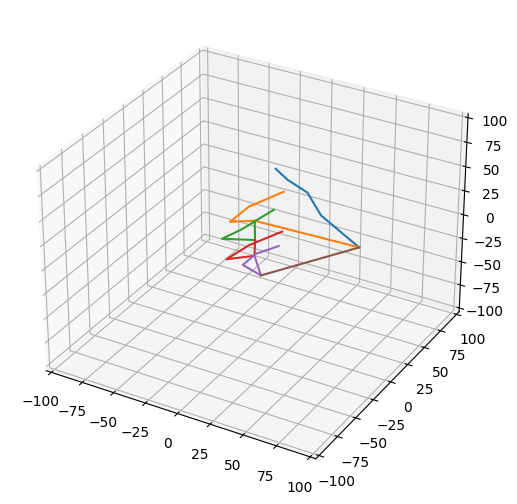

In [28]:
import matplotlib.pyplot as plt

fig, ax = annotation.configure_plot()

# This is the order to draw and connect vertices in. Take a look at the keypoint ordering in the first cell to get an idea of how this works
drawing_order = [[0, 1, 2, 3, 4], [0, 5, 6, 7, 8], [5, 9, 10, 11, 12], [9, 13, 14, 15, 16], [13, 17, 18, 19, 20], [17, 0]]
# This is size for the 3D scene
bounds = (-100, 100)
# We need to reorder how the X, Y, and Z variables are used to convert Z to up and Y to forward
xyz_order = (0, 2, 1)
# And finally, we need to flip the new forward coordinate as it's backwards
xyz_scale = (1, 1, -1)
annotation.plot_hand(0, ax, drawing_order, bounds, xyz_order=xyz_order, xyz_scale=xyz_scale)

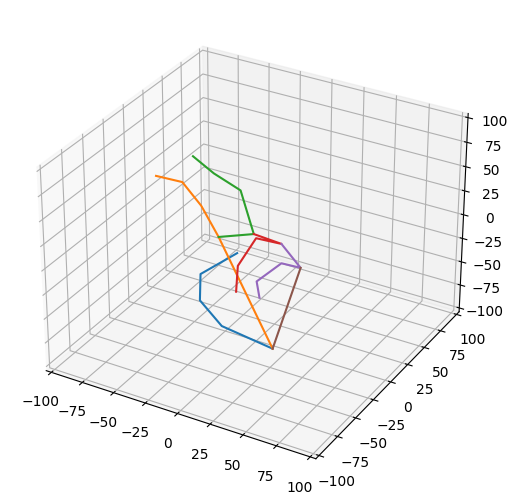

In [30]:
# And the second pose
fig, ax = annotation.configure_plot()
annotation.plot_hand(1, ax, drawing_order, bounds, xyz_order=xyz_order, xyz_scale=xyz_scale)
plt.show()